In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import yaml
import nltk

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3

In [3]:
filepaths = yaml.load(open("/home/guilherme/Desktop/dissertation/config/filepaths.yaml"))

/tmp/ipykernel_73280/4175686493.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  filepaths = yaml.load(open("/home/guilherme/Desktop/dissertation/config/filepaths.yaml"))


In [4]:
filenames = os.listdir(filepaths["01_youtube_raw"])

PERSPECTIVE_CHAR_LIMIT = 3000
n_small_corpus = 0
n_curse_words = 0

for file in filenames:
    with open(os.path.join(filepaths["01_youtube_raw"], file)) as f:
        content = f.read()
    
    if len(content) <= PERSPECTIVE_CHAR_LIMIT:
        n_small_corpus += 1
    
    n_curse_words += len(re.findall("\[ __ \]+", content))

In [5]:
n_files = len(filenames)

print("Basic Statistics")
print("----------------")
print(f"  - Percentage of data with less than 5000 characters is {n_small_corpus/n_files*100:0.2f}%")
print(f"  - Average number of curse words is {n_curse_words/n_files:0.2f} per file")

Basic Statistics
----------------
  - Percentage of data with less than 5000 characters is 6.62%
  - Average number of curse words is 0.78 per file


---

In [6]:
df_download_info = pd.read_csv(filepaths["00_youtube_data_description"])

print("Basic Statistics")
print("----------------")
print(f"  - There are {df_download_info.movie.nunique()} different movies")

Basic Statistics
----------------
  - There are 50 different movies


In [22]:
df_download_info.group.value_counts()

White Man      315
White Woman    171
Black Man      106
Black Woman     45
Name: group, dtype: int64

---

In [7]:
df_to_download = pd.read_csv(filepaths["00_youtube_data_description"])

In [8]:
print(f"Initially, there were {df_to_download.shape[0]} videos")

Initially, there were 637 videos


---

In [9]:
filenames = os.listdir(filepaths["04_youtube_scored"])

print(f"  - There are {len(filenames)} different review videos")

  - There are 634 different review videos


---

### Corpus Size Distribution

In [10]:
filenames = os.listdir(filepaths["02_youtube_preprocessed"])

corpus_sizes = []
for file in filenames:
    with open(os.path.join(filepaths["02_youtube_preprocessed"], file)) as f:
        content = f.read()
    
    corpus_sizes.append(len(content))

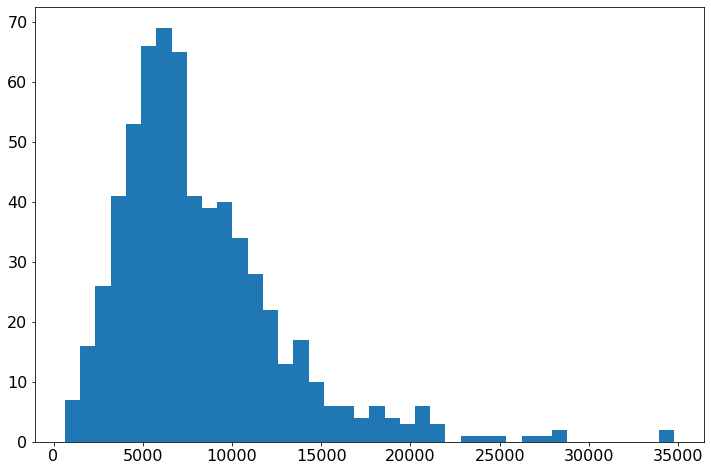

In [11]:
plt.subplots(figsize=(12,8))
plt.hist(corpus_sizes, bins=40)
plt.show()

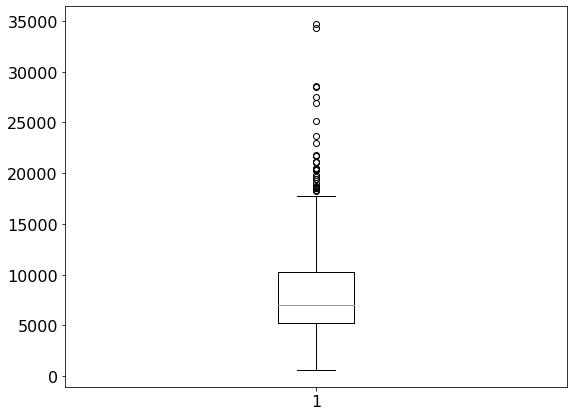

In [12]:
plt.subplots(figsize=(9,7))
plt.boxplot(corpus_sizes)
plt.show()

---

### Demographic Groups' Proportions

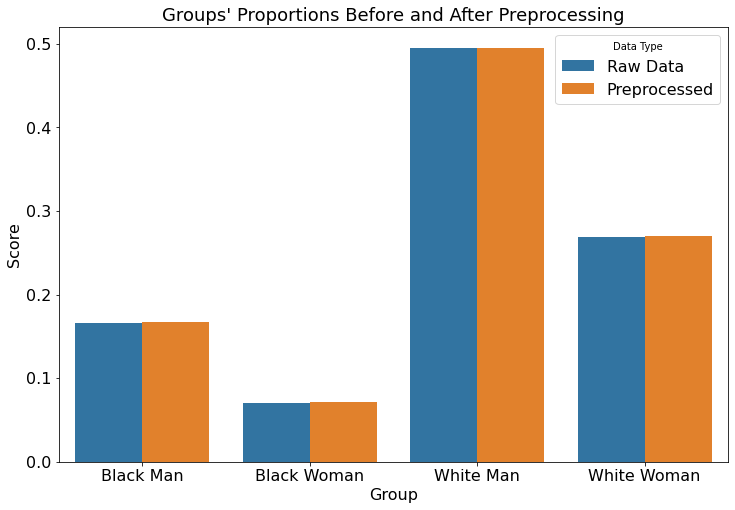

In [23]:
df_raw = pd.read_csv(filepaths["00_youtube_data_description"])

filenames = os.listdir(filepaths["02_youtube_preprocessed"])

processed_proportions = {}
for group in df_raw.group.unique():
    for _, row in df_raw[df_raw.group == group].iterrows():
        video_id_and_channel = row["url"].split("v=")[1]
        video_id = video_id_and_channel.split("&")[0]

        if video_id in filenames:  
            processed_proportions[group] = processed_proportions.get(group, 0) + 1/len(filenames)


raw_proportions = df_raw.groupby("group").movie.count()/df_raw.shape[0]

df1 = pd.DataFrame(raw_proportions.reset_index().values, columns=["Group", "Score"])
df1["Data Type"] = "Raw Data"

df2 = pd.DataFrame(processed_proportions.items(), columns=["Group", "Score"])
df2["Data Type"] = "Preprocessed"

df = pd.concat([df1, df2])

plt.subplots(figsize=(12,8))
sns.barplot(x="Group", y="Score", hue="Data Type", data=df)
plt.title("Groups' Proportions Before and After Preprocessing")
plt.show()

In [14]:
df

,Group,Score,Data Type
0,Black Man,0.166405,Raw Data
1,Black Woman,0.070644,Raw Data
2,White Man,0.494505,Raw Data
3,White Woman,0.268446,Raw Data
0,White Man,0.495268,Preprocessed
1,Black Man,0.167192,Preprocessed
2,White Woman,0.269716,Preprocessed
3,Black Woman,0.070978,Preprocessed


---

### More Frequent Words

In [15]:
group_to_content = {}

df = pd.read_csv(filepaths["00_youtube_data_description"])
for group in df.group.unique():
    dfs = []
    for _, row in df[df.group == group].iterrows():
        video_id_and_channel = row["url"].split("v=")[1]
        video_id = video_id_and_channel.split("&")[0]

        try:
            dfs.append(pd.read_csv(os.path.join(filepaths["04_youtube_scored"], video_id)))
        except:
            pass

    df_group = pd.concat(dfs)
    
    df_group = df_group[~df_group.has_swearing]
    df_group = df_group.sort_values(by="perspective_score", ascending=False)[:100]
    group_to_content[group] = ' '.join(df_group.text.values)
    
    del dfs

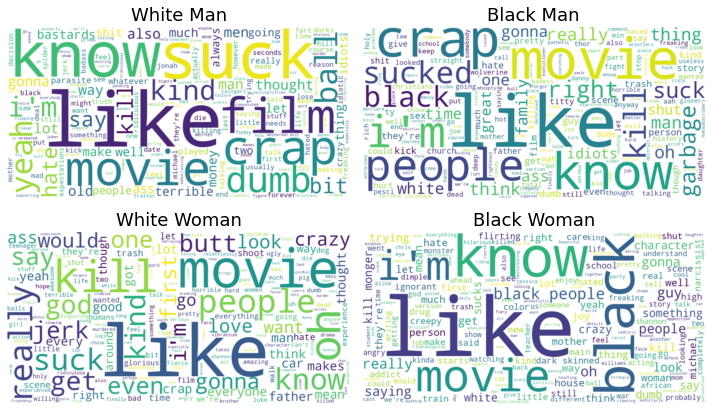

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10,6))

for i, (group, content) in enumerate(group_to_content.items()):
    wordcloud = WordCloud(
        stopwords=stopwords.words("english"),
        background_color="white",
        width=1600, height=800
    ).generate(content)

    axs[i//2, i%2].imshow(wordcloud, interpolation='bilinear')
    axs[i//2, i%2].set_title(f"{group}")
    axs[i//2, i%2].set_axis_off()

plt.tight_layout()
plt.savefig(os.path.join(filepaths["youtube_imgs"], "wordclouds.pdf"))
plt.show()

---

### How many content producers are there?

In [17]:
content_creators = {}

df = pd.read_csv(filepaths["00_youtube_data_description"])
for group in df.group.unique():
    dfs = []
    for _, row in df[df.group == group].iterrows():
        video_id_and_channel = row["url"].split("v=")[1]
        video_id = video_id_and_channel.split("&")[0]
        
        channel = row["url"].split("ab_channel=")[1]
        try:
            pd.read_csv(os.path.join(filepaths["04_youtube_scored"], video_id))
            content_creators[group] = content_creators.get(group, []) + [channel]
        except:
            pass

In [18]:
for group, creators in content_creators.items():
    content_creators[group] = len(Counter(creators))

In [19]:
content_creators

{'White Man': 177, 'Black Man': 57, 'White Woman': 84, 'Black Woman': 30}

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

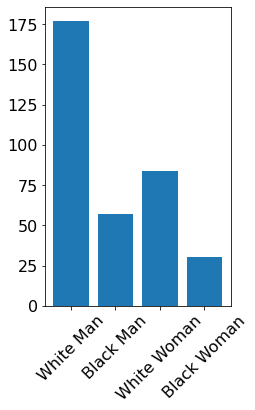

In [20]:
plt.bar(content_creators.keys(), content_creators.values())
plt.xticks(rotation=45)